# Introduction

In this notebook, I've used **CNN** to perform Image Classification on the Brain Tumor dataset.<br>
Since this dataset is small, if we train a neural network to it, it won't really give us a good result.<br>
Therefore, I'm going to use the concept of **Transfer Learning** to train the model to get really accurate results.

<img src="https://miro.medium.com/max/2800/1*TUF_YfybJPQ8WA0siWeJTg@2x.jpeg" alt="Brain" style="width: 800px;">

### Note

If you find this notebook helpful and intuitive, feel free to upvote it! Do give me your suggestions or opinions so that I can improve my work! I will highly appreciate it! Thank you! :)

---

# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

# Color

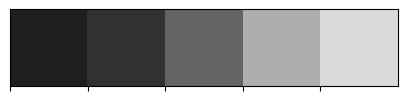

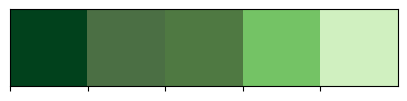

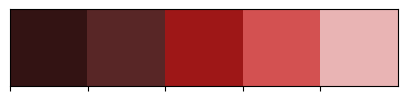

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [4]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('data','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('data','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 91.37it/s]


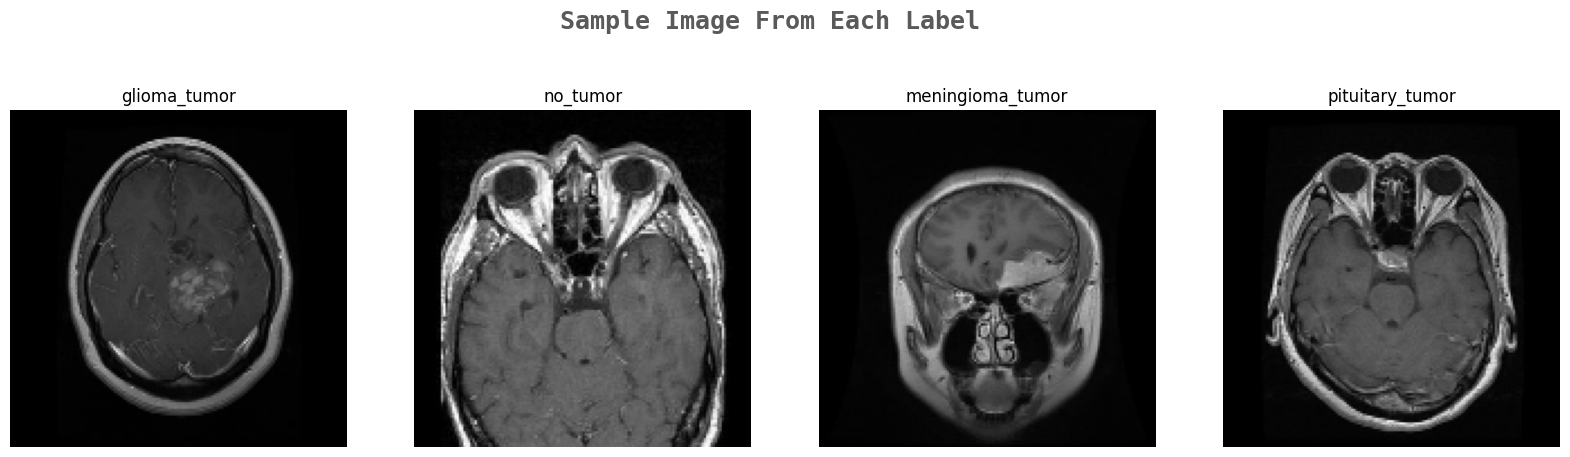

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(3264, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [10]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [11]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

We finally compile our model.

In [13]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

In [15]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7224 - loss: 0.6994
Epoch 1: val_accuracy improved from -inf to 0.82993, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7236 - loss: 0.6968 - val_accuracy: 0.8299 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9332 - loss: 0.1850
Epoch 2: val_accuracy improved from 0.82993 to 0.85374, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9332 - loss: 0.1848 - val_accuracy: 0.8537 - val_loss: 0.5973 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9394 - loss: 0.1887
Epoch 3: val_accuracy improved from 0.85374 to 0.94218, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9396 - loss: 0.1884 - val_accuracy: 0.9422 - val_loss: 0.2163 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9667 - loss: 0.0931
Epoch 4: val_accuracy did not improve from 0.94218
83/83 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9667 - loss: 0.0931 - val_accuracy: 0.8878 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 5/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9709 - loss: 0.0779
Epoch 5: val_accuracy did not improve from 0.94218

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9709 - loss: 0.0778 - val_accuracy: 0.9184 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 6/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9871 - loss: 0.0547
Epoch 6: val_accuracy improved from 0.94218 to 0.96939, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9871 - loss: 0.0545 - val_accuracy: 0.9694 - val_loss: 0.1254 - learning_rate: 3.0000e-04
Epoch 7/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9912 - loss: 0.0225
Epoch 7: val_accuracy did not improve from 0.96939
83/83 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9912 - loss: 0.0224 - val_accuracy: 0.9694 - val_loss: 0.1034 - learning_rate: 3.0000e-04
Epoch 8/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9962 - loss: 0.0113
Epoch 8: val_accuracy improved from 0.96939 to 0.97279, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9962 - loss: 0.0114 - val_accuracy: 0.9728 - val_loss: 0.1157 - learning_rate: 3.0000e-04
Epoch 9/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9975 - loss: 0.0111
Epoch 9: val_accuracy did not improve from 0.97279
83/83 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9975 - loss: 0.0111 - val_accuracy: 0.9694 - val_loss: 0.0986 - learning_rate: 3.0000e-04
Epoch 10/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9992 - loss: 0.0054
Epoch 10: val_accuracy did not improve from 0.97279

Epoch 10: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
83/83 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9992 - loss: 0.0054 - val_accuracy: 0.9728 - val_loss: 0.1072 - learning_rate: 3.0000e-04
Epoch 11/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9963 - loss: 0.0082
Epoch 11: val_accuracy improved from 0.97279 to 0.97959, saving model to effnet.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9963 - loss: 0.0082 - val_accuracy: 0.9796 - val_loss: 0.0992 - learning_rate: 9.0000e-05
Epoch 12/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9979 - loss: 0.0055
Epoch 12: val_accuracy did not improve from 0.97959
83/83 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9979 - loss: 0.0055 - val_accuracy: 0.9796 - val_loss: 0.1018 - learning_rate: 9.0000e-05


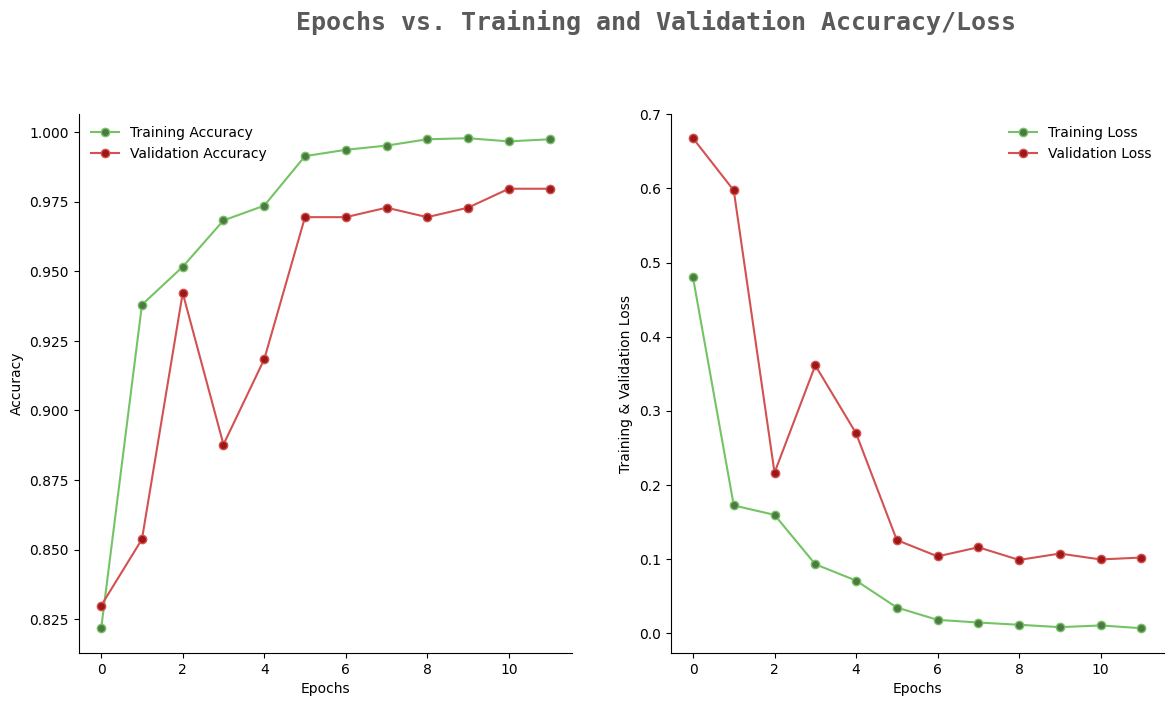

In [19]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [20]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step


---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [21]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        93
           1       1.00      1.00      1.00        51
           2       0.98      0.97      0.97        96
           3       0.98      1.00      0.99        87

    accuracy                           0.98       327
   macro avg       0.98      0.98      0.98       327
weighted avg       0.98      0.98      0.98       327



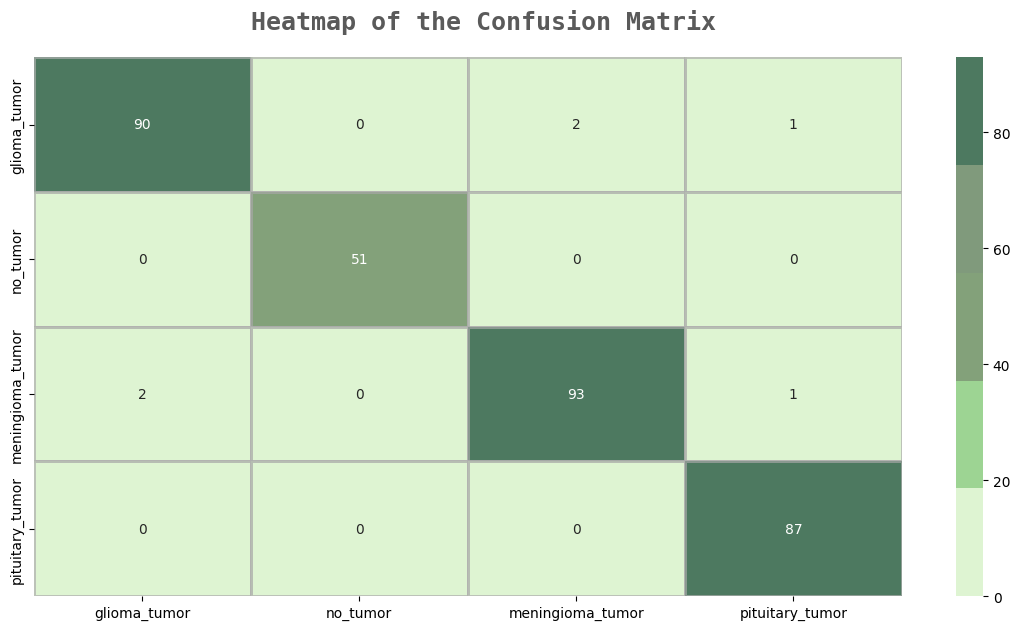

In [22]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

# Bonus Content: Widgets

I've made these Widgets in which we can upload images from our local machine and predict whether the MRI scan has a Brain Tumour or not and to classify which Tumor it is.<br>
Unfortunately, it doesn't work on Kaggle but you can play around with this by downloading the notebook on your machine :)

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value=(), description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

---

# Conclusion

In this notebook, I performed Image Classification with the help of CNN using Transfer Learning which gave an accuracy of around 98%.<br>
I also made widgets which can make predictions on an image from your local machine!

---

# <center>Thank You!

In [1]:
# convert_model.py
import tensorflow as tf

model = tf.keras.models.load_model('effnet.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('effnet.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\krish\AppData\Local\Temp\tmpyhcnfg2w\assets


INFO:tensorflow:Assets written to: C:\Users\krish\AppData\Local\Temp\tmpyhcnfg2w\assets


Saved artifact at 'C:\Users\krish\AppData\Local\Temp\tmpyhcnfg2w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2043283981328: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2043283981520: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2043260999568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2043261000336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2043260999760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2043261001104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2043260998416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2043260997840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2043261001680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2043261002256: TensorSpec(shape=(), dtype=tf.resource, n